In [3]:
import re
import json
import fileinput
import pandas as pd
import gensim
import numpy as np
import nltk
import os
import random
import sklearn.metrics
import sklearn.model_selection
from sklearn.manifold import TSNE
import sklearn.datasets
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from gensim.models.word2vec import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, sent_tokenize, TweetTokenizer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix
from google.colab import files
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import io

Using TensorFlow backend.


In [2]:
!pip install gensim

    100% |████████████████████████████████| 22.6MB 66kB/s 
    100% |████████████████████████████████| 133kB 8.5MB/s 
    100% |████████████████████████████████| 1.4MB 932kB/s 
    100% |████████████████████████████████| 61kB 7.9MB/s 
    100% |████████████████████████████████| 4.1MB 353kB/s 
    100% |████████████████████████████████| 552kB 2.1MB/s 
  Running setup.py bdist_wheel for smart-open ... - done
  Stored in directory: /content/.cache/pip/wheels/cf/54/36/b003d8c2d26aadffc21f0677009ed53cf9575a97fc71fbba76
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /content/.cache/pip/wheels/31/9c/20/996d65ca104cbca940b1b053299b68459391c01c774d073126
Successfully built smart-open bz2file


In [3]:
!pip install tqdm

    100% |████████████████████████████████| 61kB 2.9MB/s 


In [0]:
seed = 7
np.random.seed(seed)

In [8]:
uploaded = files.upload()

Saving train_labeled_data.csv to train_labeled_data (1).csv


In [0]:
df = pd.read_csv(io.StringIO(uploaded['train_labeled_data.csv'].decode('ISO-8859-1')))

In [0]:
df.columns = ["sentiment_label", "tweet_id", "date", "flag", "user", "tweet"]

In [0]:
df.drop(['tweet_id', 'date', 'flag', 'user'], axis=1, inplace=True)

In [0]:
df1 = df[df.sentiment_label.isnull() == False]

In [0]:
df1 = df[df.tweet.isnull() == False]

In [0]:
df1.reset_index(inplace=True)

In [0]:
df1.drop('index', axis=1, inplace=True)

In [0]:
df1['sentiment_label'] = df1['sentiment_label'].map( {4:1, 0:0} )

In [0]:
# Extract features from a given text
def extract_tokens(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = list(filter(lambda t: not t.startswith('@'), tokens))
    tokens = list(filter(lambda t: not t.startswith('#'), tokens))
    tokens = list(filter(lambda t: not t.startswith('http'), tokens))
    
    return tokens

In [0]:
def data_process(data):
    data['tokens'] = data['tweet'].map(extract_tokens)
    
    return data

In [0]:
df1 = data_process(df1)

In [0]:
df1 = df1[df1.tokens != 'NC']
df1.reset_index(inplace=True)
df1.drop('index', inplace=True, axis=1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(np.array(df1.tokens), np.array(df1.sentiment_label), test_size=0.2)

In [0]:
lsentence = gensim.models.doc2vec.LabeledSentence

In [0]:
def label_tweets(text, ltype):
    labelized = []
    for i,v in tqdm(enumerate(text)):
        label = '%s_%s'%(ltype,i)
        labelized.append(lsentence(v, [label]))
    return labelized

In [24]:
x_train = label_tweets(x_train, 'TRAIN')
x_test = label_tweets(x_test, 'TEST')

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """
1279999it [00:10, 127155.52it/s]
320000it [00:02, 110259.64it/s]


In [25]:
x_train[0]

LabeledSentence(words=['lol', 'You', 'will', 'get', "what's", 'coming', 'to', 'you', ',', 'in', 'a', 'good', 'way', 'I', 'mean', '.', "That's", 'the', 'way', 'of', 'talented', 'authors', '.'], tags=['TRAIN_0'])

In [0]:
n_dim = 500

In [27]:
w2v_model = Word2Vec(size=n_dim, min_count=10)
w2v_model.build_vocab([x.words for x in tqdm(x_train)])
w2v_model.train([x.words for x in tqdm(x_train)], total_examples = w2v_model.corpus_count, epochs = w2v_model.iter )

100%|██████████| 1279999/1279999 [00:00<00:00, 1888206.32it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(69370867, 94153740)

In [28]:
w2v_model.most_similar('good')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('great', 0.7462680339813232),
 ('goood', 0.7238764762878418),
 ('rough', 0.6622070074081421),
 ('gooood', 0.656705379486084),
 ('tough', 0.6529021263122559),
 ('nice', 0.6481397151947021),
 ('fab', 0.645189106464386),
 ('goooood', 0.6447819471359253),
 ('fantastic', 0.6254699230194092),
 ('gd', 0.6116144061088562)]

In [0]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:100])

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


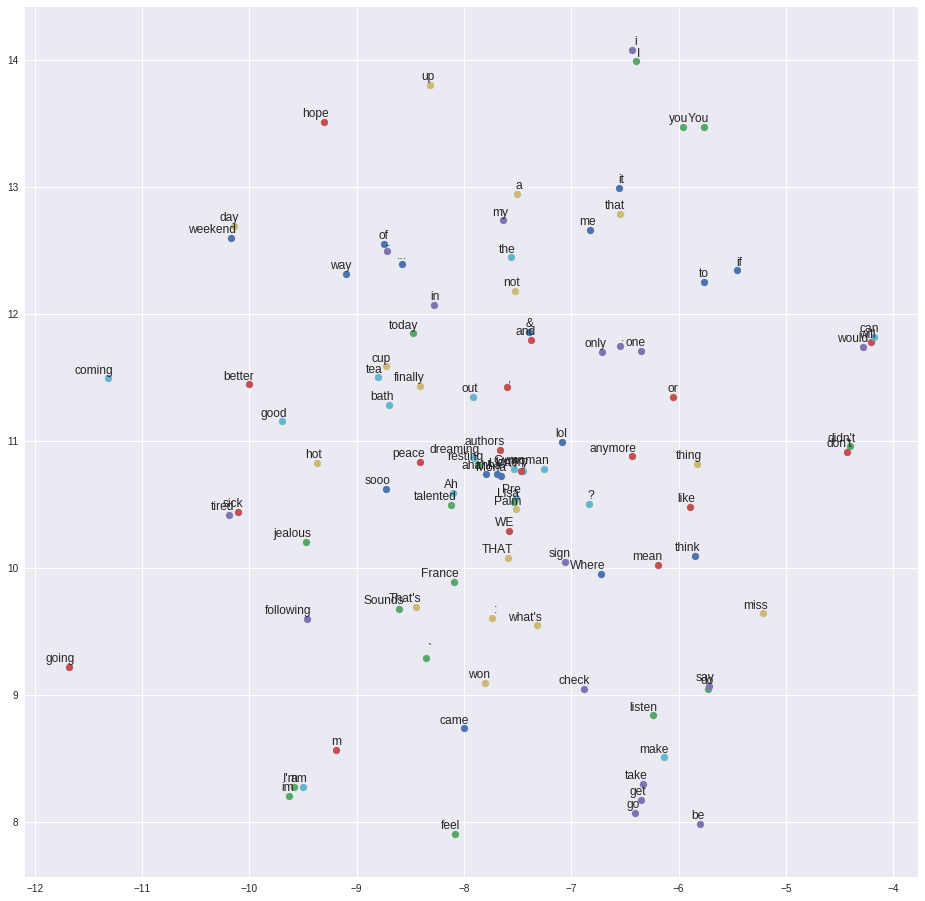

In [30]:
tsne_plot(w2v_model)

In [0]:
build_matrix = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
tfidf_matrix = build_matrix.fit_transform([x.words for x in x_train])
tfidf = dict(zip(build_matrix.get_feature_names(), build_matrix.idf_))

In [0]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [0]:
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
152464it [00:43, 3495.46it/s]

1279999it [06:10, 3452.19it/s]


In [0]:
def classifier_model():
  model = Sequential()
  model.add(Dense(32, activation='relu', input_dim=500))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

#model.fit(train_vecs_w2v, train_vecs_w2v, validation_split=0.33, epochs=9, batch_size=32, verbose=2)

In [2]:
estimator = KerasClassifier(build_fn=classifier_model, epochs=9, batch_size=32, verbose=2)

NameError: ignored

In [0]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [7]:
results = cross_val_score(estimator, train_vecs_w2v, y_train, cv=kfold)
print("Model: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

NameError: ignored